# Technical test - Thomas Jacquot 


**Instructions**: 

The aim of the project is to write a functional and structured code in python. This
code should be able to make a prediction on the dataset Auto Insurance (available 
[here](https://www.kaggle.com/c/auto-insurance-fall-2017/data)) of target TARGET_FLAG.
This code should also explicitly return the value of the performance of the algorithms
tested using the appropriate metric and generate a csv file with the predictions.

Performance is not the main goal. The objective of the project is to write the main steps of
a data science project in 2 hours with a proper style and well written comments.
The code should be written in python files or ipython notebook using the
appropriate libraries. We would rather have a link to a github repository. 

**Data**: 

We have 4 csv files. The two we are interested in are *train_auto.csv* and *test_auto.csv*. 

In those tables, most variables have an explicit name. However, some of them deserve some further explanation in order to fully understand the database. The table below summarizes my hypothesis regarding their meaning. 

| Name of the variable | Explanation | French equivalent |
| --- | --- | --- |
| TARGET_FLAG | Binary variable (0=No claim, 1=Claim) | Variable binaire (0 = Pas de sinistre, 1 = Sinsitre) |
| TARGET_AMOUNT | Claim amount | Montant du sinistre |
| YOJ | Year of Joining | Ancienneté de l'assuré |
| BLUEBOOK | Estimated value of the car | Montant à l'argus |
| MVR_POINTS | Motor Vehicule Record Points | Score évaluant la conduite (eq. aux points du permis de conduire) |
| TIF | Time in force | Nombre d'années du contrat en vigueur  |

We also have at our disposal two other csv files. The first one, *SHELL_AUTO.csv* seems to contain the prediction of the claims amounts for the customers in the test database. The other, *MEAN_AUTO.csv*,  shows a single figure for these clients (probably the annual premium amount). 

## 1. Data exploration and preprocessing 


In [1]:
#Some useful libraries for the project
import pandas as pd 
import pandas_profiling
import numpy as np
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import warnings
warnings.filterwarnings('ignore')

### A. Loading the dataset 

Firstly, we have a look at the train dataset. As you will see, the base is relatively important. It contains information from more than 8,000 policyholders. Many variables (more than 20) are filled in for each of them.

In [2]:
train_auto = pd.read_csv('train_auto.csv')
print("This table includes {} lines and {} columns".format(train_auto.shape[0],train_auto.shape[1]))
print("Let's have a look:")
train_auto.head(10)

This table includes 8161 lines and 26 columns
Let's have a look:


,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
5,7,1,2946.0,0,34.0,1,12.0,"$125,301",Yes,$0,...,"$17,430",1,Sports Car,no,$0,0,No,0,7.0,Highly Urban/ Urban
6,8,0,0.0,0,54.0,0,NaN,"$18,755",No,NaN,...,"$8,780",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
7,11,1,4021.0,1,37.0,2,NaN,"$107,961",No,"$333,680",...,"$16,970",1,Van,yes,"$2,374",1,Yes,10,7.0,Highly Urban/ Urban
8,12,1,2501.0,0,34.0,0,10.0,"$62,978",No,$0,...,"$11,200",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban
9,13,0,0.0,0,50.0,0,7.0,"$106,952",No,$0,...,"$18,510",7,Van,no,$0,0,No,1,17.0,z_Highly Rural/ Rural


In [3]:
#List of variables
resume_var = pd. DataFrame()
resume_var['Col. 1'] = train_auto.columns[0:13]
resume_var['Col. 2'] = train_auto.columns[13:26]
print('Here are the variables contained in the base : ')
resume_var

Here are the variables contained in the base : 


,Col. 1,Col. 2
0,INDEX,JOB
1,TARGET_FLAG,TRAVTIME
2,TARGET_AMT,CAR_USE
3,KIDSDRIV,BLUEBOOK
4,AGE,TIF
5,HOMEKIDS,CAR_TYPE
6,YOJ,RED_CAR
7,INCOME,OLDCLAIM
8,PARENT1,CLM_FREQ
9,HOME_VAL,REVOKED


We generate a report summarizing the main characteristics and statistics of the database. It provides information on the types of variables in the database but also on missing values, correlations, etc... It will be very useful to us in order to make the necessary modifications to the database. If the report is not displayed, a version registered under the name *train_auto_report.html* is available in the repository. 

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_auto, title='Pandas Profiling Report')
profile.to_file("train_auto_report.html")
profile.to_widgets()

### B. Recoding some variables

Some variables require recoding. This is the case for categorical/strings variables. The following code convert them to numeric values.   

In [5]:
data = train_auto

#Index correctly the database
data = data.set_index('INDEX')

#Convert money amounts to real numbers
mask = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
data[mask] = data[mask].replace('[\$,]', '', regex=True).astype(float)

In [6]:
#Transform string variables to binary ones
data['PARENT1'] = data['PARENT1'].map(dict(Yes=1, No=0))
data['RED_CAR'] = data['RED_CAR'].map(dict(yes=1, no=0))
data['REVOKED'] = data['REVOKED'].map(dict(Yes=1, No=0))

#case of binary categorical variables
mask = ['MSTATUS','SEX', 'CAR_USE', 'URBANICITY']
data =  pd.concat([data, pd.get_dummies(data[mask], drop_first = True)], axis=1)
data = data.drop(data[mask], axis=1)

#Non binary categorical variable
mask = ['EDUCATION', 'JOB', 'CAR_TYPE']
data =  pd.concat([data, pd.get_dummies(data[mask])], axis=1)
data = data.drop(data[mask], axis=1)

### C. MISSING VALUES 

We delete the lines for which we don't have a filled TARGET_FLAG.  Indeed, we can't learn about these data if we don't have the target variable. 

In [7]:
#Delete customers for whom we do not have the target_flag 
data = data.dropna(subset =['TARGET_FLAG'])

We have noticed that clients who are missing their age have dependent children. It is proposed to replace their age with the median age of clients with the same number of children. This change is made by the following code. 

In [8]:
#Treat missing value for the variable AGE
df_age = data[data['AGE'].isnull()]
for i in range(df_age.shape[0]): 
    ind = df_age.index[i]
    home_kids = df_age.iloc[i]['HOMEKIDS']
    val = np.nanmedian(data[data['HOMEKIDS']==home_kids]['AGE'])
    data.loc[ind,'AGE'] = val

Missing values in the other cells are also replaced by the corresponding column median. 

In [9]:
data = data.fillna(data.median())

### D. Descriptives statistics 

The following tables gives us the main statistics concerning the dataset. For example, the average age of the insured is 44.7 years old, earns $61,468 per year and has been with the insurance company for more than 10 years. These statistics can be completed with the representation of the distributions found on the graphs below. 

In [10]:
data.describe()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,TRAVTIME,...,JOB_Manager,JOB_Professional,JOB_Student,JOB_z_Blue Collar,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV
count,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,...,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000
mean,0.263816,1504.324648,0.171057,44.787526,0.721235,10.527141,61468.956991,0.131969,155225.066658,33.485725,...,0.121064,0.136870,0.087244,0.223625,0.262835,0.082833,0.170200,0.111138,0.091901,0.281093
std,0.440728,4704.026930,0.511534,8.625455,1.116323,3.978654,46291.833512,0.338478,125407.348846,15.908333,...,0.326221,0.343732,0.282210,0.416699,0.440201,0.275646,0.375831,0.314323,0.288903,0.449560
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,29707.000000,0.000000,0.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,54028.000000,0.000000,161160.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,83304.000000,0.000000,233352.000000,44.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,107586.136160,4.000000,81.000000,5.000000,23.000000,367030.000000,1.000000,885282.000000,142.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As we can see on the graph below, we are dealing with an unbalanced dataset. Class 1 of the target variable is under-represented. In the next section we will see how to solve this problem. 

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='count'>

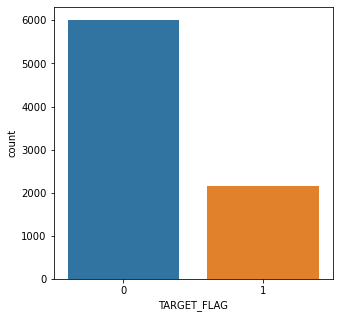

In [11]:
#Distribution of target variable 
fig = plt.figure(figsize=(5,5))
sns.countplot(data['TARGET_FLAG'])

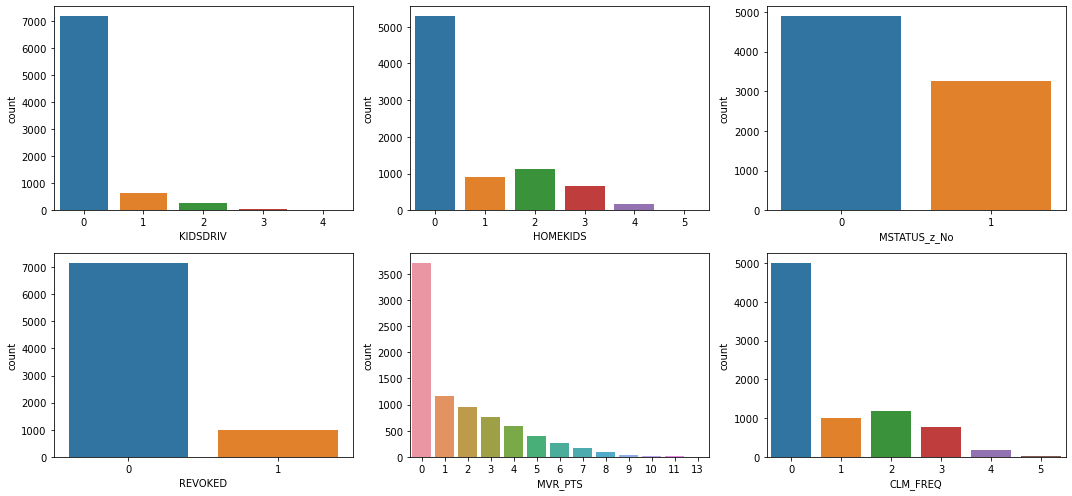

In [12]:
#Distributions of integer variables
fig = plt.figure(figsize=(15,7))
fig.add_subplot(2,3,1)
sns.countplot(data['KIDSDRIV'])
fig.add_subplot(2,3,2)
sns.countplot(data['HOMEKIDS'])
fig.add_subplot(2,3,3)
sns.countplot(data['MSTATUS_z_No'])
plt.tight_layout()
fig.add_subplot(2,3,4)
sns.countplot(data['REVOKED'])
plt.tight_layout()
fig.add_subplot(2,3,5)
sns.countplot(data['MVR_PTS'])
plt.tight_layout()
fig.add_subplot(2,3,6)
sns.countplot(data['CLM_FREQ'])
plt.tight_layout()

<AxesSubplot:xlabel='TRAVTIME', ylabel='Density'>

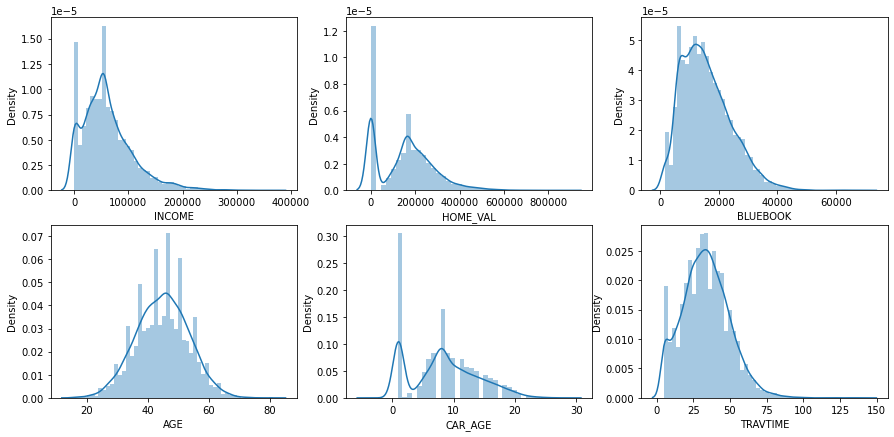

In [13]:
#Affichage du prix des maisons 
fig = plt.figure(figsize=(15,7))

fig.add_subplot(2,3,1)
sns.distplot(data['INCOME'])

fig.add_subplot(2,3,2)
sns.distplot(data['HOME_VAL'])

fig.add_subplot(2,3,3)
sns.distplot(data['BLUEBOOK'])

fig.add_subplot(2,3,4)
sns.distplot(data['AGE'])

fig.add_subplot(2,3,5)
sns.distplot(data['CAR_AGE'])

fig.add_subplot(2,3,6)
sns.distplot(data['TRAVTIME'])

The above statistics are far from being exhaustive but do not seem too problematic. Their distributions are classical. We do not see too many extreme values. It may be surprising, for example, to see peaks of concentration in 0 for INCOME. This is probably explained by the fact that the insured is a student or is unemployed. Similar explanations can be made for the variable HOME_VAL. 

In [14]:
corr_tab = data.corr()
col = corr_tab[abs(corr_tab['TARGET_FLAG'])>0.1].index[:]
corr_tab[col].loc[col]

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,INCOME,PARENT1,HOME_VAL,BLUEBOOK,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,MSTATUS_z_No,CAR_USE_Private,URBANICITY_z_Highly Rural/ Rural,EDUCATION_z_High School,JOB_Manager,JOB_z_Blue Collar,CAR_TYPE_Minivan
TARGET_FLAG,1.000000,0.534246,0.103668,-0.103757,0.115621,-0.137790,0.157622,-0.178485,-0.103383,0.138084,0.216196,0.151939,0.219197,0.135125,-0.142674,-0.224251,0.109769,-0.105395,0.101787,-0.136999
TARGET_AMT,0.534246,1.000000,0.055394,-0.041943,0.061988,-0.056383,0.096965,-0.083476,-0.004700,0.070953,0.116419,0.061385,0.137866,0.087661,-0.098614,-0.120974,0.042098,-0.064606,0.061830,-0.075267
KIDSDRIV,0.103668,0.055394,1.000000,-0.075059,0.464015,-0.045831,0.196604,-0.019495,-0.021549,0.020403,0.037063,0.043062,0.053566,-0.042461,-0.001422,0.037124,0.031525,-0.011019,0.037842,-0.014106
AGE,-0.103757,-0.041943,-0.075059,1.000000,-0.445640,0.176002,-0.314195,0.204684,0.165134,-0.029375,-0.023870,-0.038540,-0.071816,-0.090985,0.033213,-0.051052,-0.116383,0.089411,-0.064620,0.011030
HOMEKIDS,0.115621,0.061988,0.464015,-0.445640,1.000000,-0.154862,0.449274,-0.108018,-0.107894,0.029911,0.029349,0.045116,0.060601,-0.043526,0.004458,0.063483,0.090297,-0.071874,0.043402,-0.039664
INCOME,-0.137790,-0.056383,-0.045831,0.176002,-0.154862,1.000000,-0.072912,0.543031,0.419044,-0.044121,-0.046311,-0.020120,-0.060661,0.030609,-0.078594,-0.200240,-0.299980,0.194835,-0.032193,0.037371
PARENT1,0.157622,0.096965,0.196604,-0.314195,0.449274,-0.072912,1.000000,-0.254536,-0.050458,0.034689,0.048742,0.049719,0.068453,0.477228,-0.006194,0.022210,0.030870,-0.019295,0.016644,-0.019800
HOME_VAL,-0.178485,-0.083476,-0.019495,0.204684,-0.108018,0.543031,-0.254536,1.000000,0.251733,-0.067271,-0.091283,-0.049181,-0.082440,-0.446337,-0.026700,-0.116396,-0.174657,0.124280,0.011975,0.024654
BLUEBOOK,-0.103383,-0.004700,-0.021549,0.165134,-0.107894,0.419044,-0.050458,0.251733,1.000000,-0.029518,-0.036341,-0.025797,-0.039131,0.007743,-0.225099,-0.087741,-0.147462,0.089065,-0.020696,0.041401
OLDCLAIM,0.138084,0.070953,0.020403,-0.029375,0.029911,-0.044121,0.034689,-0.067271,-0.029518,1.000000,0.495131,0.418104,0.264485,0.045920,-0.035768,-0.151083,0.021689,-0.007520,0.010379,-0.037755


In the table below we look at the correlations for the variables which are most correlated to TARGET_FLAG (variable we will try to predict). Unsurprisingly we see that previous claims have a huge influence on TARGET_FLAG. Conversely, as was to be expected, having a red car does not influence. The most correlated variables are assumed to be the most important in our prediction models.  

### E.Train/test split 

As the variable TARGET_FLAG is not available in the file *test_auto.csv*, we choose to separate *data* into a training sample and a test sample. 

In [15]:
#Train/test split
from sklearn.model_selection import train_test_split
X = data.drop(['TARGET_FLAG', 'TARGET_AMT'], axis=1)
y = data['TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### F. Rebalancing of the train set 

In the section D, we saw that the dataset was unbalanced. We will therefore rebalance the training set using the SMOTE algorithm. The SMOTE algorithm uses the KKN method to over-sample the minority class. 

In [16]:
#Rebalance with SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train.to_numpy(), y_train.to_numpy() )

In [17]:
X_train_res = pd.DataFrame(X_res, columns = X.columns)
y_train_res = pd.DataFrame(y_res, columns = ['TARGET_FLAG'])

Now, both class of the target variable are equally represented as the graph bellow shows. 

<AxesSubplot:xlabel='TARGET_FLAG', ylabel='count'>

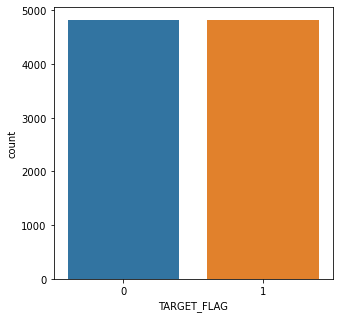

In [18]:
#Distribution of target variable 
fig = plt.figure(figsize=(5,5))
sns.countplot(y_train_res['TARGET_FLAG'])

## 2. Training model & Performance evaluation

### A. Simple logistic regression 

We are in a binary classification problem, so we start by implementing a logistic regression model. 

In [19]:
#First logistic regression##########################################
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg', max_iter=1000)
lr.fit(X_train_res,y_train_res)
y_pred = lr.predict(X_test)

Let's have a look at the performance of this model. Our metric of reference will be the recall score. Let's remind its expression: 

$$ \text{Recall}= \frac{\text{True Positive}}{\text{True Positive } + \text{ False Negative}}$$

This measure is very useful to detect all positive samples and avoids too many false negatives. In our case, we clearly want to avoid false negatives because they represent insureds who are going to have a claim and for whom the model does not predict a claim. In order to be prudent, the insurer must maximize the recall. 

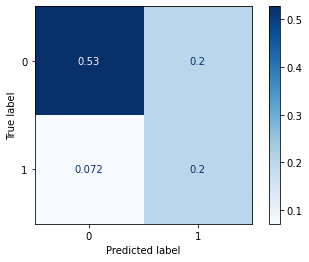

By numbers we have the following 
 [[860 329]
 [117 327]]
Accuracy on test set : 0.727
Recall on test set : 0.736
Precision on test set : 0.498
See the detailled classification report below : 
               precision    recall  f1-score   support

           0       0.88      0.72      0.79      1189
           1       0.50      0.74      0.59       444

    accuracy                           0.73      1633
   macro avg       0.69      0.73      0.69      1633
weighted avg       0.78      0.73      0.74      1633



In [20]:
#Performance evaluation ##############################################################################

#Confusion matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(estimator = lr, X = X_test,y_true= y_test, normalize='all',cmap = 'Blues') 
plt.show()
confusion = confusion_matrix(y_test, y_pred)
print("By numbers we have the following \n",confusion)

#Scores
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("Accuracy on test set : {:.3f}".format(lr.score(X_test,y_test)))
print("Recall on test set : {:.3f}".format(recall_score(y_test,y_pred)))
print("Precision on test set : {:.3f}".format(precision_score(y_test,y_pred)))

#Classification report by class
from sklearn.metrics import classification_report 
print("See the detailled classification report below : \n", classification_report(y_test, y_pred))

This model which uses logistic regression seems very satisfactory. The recall obtained is very good (higher than 0.7). Moreover, the accuracy is also higher than 0.7. Let's now try to see if we can improve the model by optimizing the hyperparameters. 

### B.Optimization of hyperparamters

In order to select the best parameters (i.e. those that maximize the recall) we will use a gridsearchCV. The best parameters will then be selected by cross validation. 

In [21]:
from sklearn.model_selection import GridSearchCV

#Grid of parameters
param_grid = {'C' : [0.001,0.01,0.1,1,10,1000],
             'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#GridSearchCV implementation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_res,y_train_res)
y_pred_gs = grid_search.predict(X_test)

#Performance evalution
confusion_gs = confusion_matrix(y_test, y_pred_gs)
print("Confusion martrix  : \n {}".format(confusion_gs))
print("Recall on test set with selected model : {:.3f}".format(grid_search.score(X_test,y_test)))
print("See the detailled classification report below : \n", classification_report(y_test, y_pred_gs))

Confusion martrix  : 
 [[861 328]
 [117 327]]
Recall on test set with selected model : 0.736
See the detailled classification report below : 
               precision    recall  f1-score   support

           0       0.88      0.72      0.79      1189
           1       0.50      0.74      0.60       444

    accuracy                           0.73      1633
   macro avg       0.69      0.73      0.69      1633
weighted avg       0.78      0.73      0.74      1633



In [26]:
#Best parameters
print('Best parameters are : {}'.format(grid_search.best_params_))

Best parameters are : {'C': 10, 'solver': 'newton-cg'}


The results obtained are almost the same when optimizing. There is only a small change in the f1-score. The selected model takes C=10 as the regularization coefficient, whereas the previous model took C=1.  

### C. Customized random forest 

Let's try another model to compare our performance. Here we apply a random forest that we optimize directly with the GridSearchCV method. 

In [22]:
#Search for best parameters for random forest estimator
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50, 100, 250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

forest_grid_search = GridSearchCV(estimator=RandomForestClassifier(),scoring='recall', param_grid=param_grid, cv= 5)
forest_grid_search.fit(X_train_res, y_train_res)
prediction_forest_gs = forest_grid_search.predict(X_test)

Best parameters are : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}


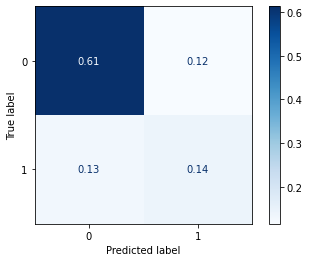

By numbers we have 
 [[1001  188]
 [ 212  232]]
Accuracy on test set : 0.755
Recall on test set  : 0.523
Precision on test set  : 0.552
See the detailled classification report below : 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1189
           1       0.55      0.52      0.54       444

    accuracy                           0.76      1633
   macro avg       0.69      0.68      0.69      1633
weighted avg       0.75      0.76      0.75      1633



In [23]:
#Best parameters
print('Best parameters are : {}'.format(forest_grid_search.best_params_))

#Confusion matrix 
plot_confusion_matrix(estimator = forest_grid_search, X = X_test,y_true= y_test, normalize='all',cmap = 'Blues')
plt.show()
confusion_forest_grid_search = confusion_matrix(y_test, prediction_forest_gs)
print("By numbers we have \n",confusion_forest_grid_search)

#Scores
print("Accuracy on test set : {:.3f}".format(accuracy_score(y_test,prediction_forest_gs)))
print("Recall on test set  : {:.3f}".format(recall_score(y_test,prediction_forest_gs)))
print("Precision on test set  : {:.3f}".format(precision_score(y_test,prediction_forest_gs)))

#Classification report by class 
print("See the detailled classification report below : \n", classification_report(y_test, prediction_forest_gs))

The results obtained with random forest are much poorer than those obtained with logistic regression. It is likely that the random forest model is overfitting the train set.  

## 3. Results validation 

We load the data from the *auto_test.csv* file and apply the same pre-processing steps we implemented for *auto_train.csv*. 

In [24]:
X_pred = pd.read_csv('test_auto.csv')

#Drop target
X_pred = X_pred.drop(['TARGET_FLAG', 'TARGET_AMT'], axis=1)
X_pred = X_pred.dropna()

#Reindex the dataframe
index = X_pred['INDEX']
X_pred = X_pred.set_index('INDEX')

#Convert money amounts to real numbers
mask = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
X_pred[mask] = X_pred[mask].replace('[\$,]', '', regex=True).astype(float)

#Transform categorical variables to numeric ones
X_pred['PARENT1'] = X_pred['PARENT1'].map(dict(Yes=1, No=0))
X_pred['RED_CAR'] = X_pred['RED_CAR'].map(dict(yes=1, no=0))
X_pred['REVOKED'] = X_pred['REVOKED'].map(dict(Yes=1, No=0))

#case of binary categorical variables
mask = ['MSTATUS','SEX', 'CAR_USE', 'URBANICITY']
X_pred =  pd.concat([X_pred, pd.get_dummies(X_pred[mask], drop_first = True)], axis=1)
X_pred = X_pred.drop(X_pred[mask], axis=1)

#others
mask = ['EDUCATION', 'JOB', 'CAR_TYPE']
X_pred =  pd.concat([X_pred, pd.get_dummies(X_pred[mask])], axis=1)
X_pred = X_pred.drop(X_pred[mask], axis=1)

Let's save the results in a csv file.

In [25]:
result = pd.DataFrame()
result['INDEX'] = index
result['TARGET_FLAG_LR'] = grid_search.predict(X_pred)
result['TARGET_FLAG_RF'] = forest_grid_search.predict(X_pred)
result.to_csv('TARGET_FLAG_PRED.csv')

## 4. Conclusion 

We have set up two predictive models that seem to be relatively efficient. They have both very good accuracy but the best remains of the logistic regression model that has a high recall for class 1. Of course we could also have tested other models (SVM, neural networks,...). 

Here the data are not in too large dimension, that is why I did not opt for a dimension reduction method (such as PCA or non-negative matrix factorization). However, if we had had more variables it might have been interesting to implement these methods or variable selection techniques. 

Finally, to conclude, I would like to point out that more advanced techniques can undoubtedly be implemented. One must simply keep in mind that the explanatory power of models is also an important issue when putting them into production.